# Market comparison
In this final notebook, we use actual marked data from `yfinance` to historically backtest our pricing model for Asian options.  We will take windows over historical data and compare the actual (discounted) payout of an array of Asian options to the expected one for geometric calls (from the formula) and arithmetic calls (from the Monte-Carlo simulation).  We will use realized volatility in the previous month as volatility in the GBM model.

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

from utils import gao_price, monte_carlo_asian


# function to annualize realized vol
def realized_vol(series, window_days=60):
    # log returns
    lr = np.log(series).diff().dropna()
    return lr.rolling(window_days).std() * np.sqrt(252)

### S&P 500
We begin by looking at the SPDR S&P 500 ETF Trust (`SPY`), an ETF designed to replicate the S&P 500 index.

In [ ]:
# --- CONFIG ---
ticker = "SPY"
expiry_days = 42  # length of Asian contract in calendar days
trail_window = 21  # days to compute realized vol before t0
r = 0.045  # risk-free rate (annual)
n_sims = 20_000  # MC paths for model pricing
n_steps = expiry_days  # MC time steps approx 1 per day
K_rel_values = [0.8, 0.9, 1.0, 1.1, 1.2]  # strike relative to spot, e.g., 1.0 = ATM
start_date = "2019-01-01"  # historical range start
end_date = "2024-12-31"  # historical range end

# helper: daily trading days ~ use business days index
prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()

# compute rolling realized vol series (one-sided trailing)
rv = realized_vol(prices, window_days=trail_window)

# choose t0 dates where we have enough trailing data and future window
all_dates = prices.index
usable_dates = []
for t0 in all_dates:
    # require t0 to have trailing window and future expiry window
    t0_idx = all_dates.get_loc(t0)
    if t0_idx - trail_window < 0:
        continue
    # compute end index for expiry
    expiry_date = t0 + pd.Timedelta(days=expiry_days)
    # find nearest trading day >= expiry_date
    if expiry_date > all_dates[-1]:
        break
    # we need expiry to be in index
    # find first trading day >= expiry_date
    future_idx = all_dates.get_indexer([expiry_date], method="bfill")[0]
    if future_idx == -1 or future_idx >= len(all_dates):
        continue
    # accept t0
    usable_dates.append(t0)

# # For speed, subsample usable_dates
# usable_dates = usable_dates[::20]

results = []
for t0 in usable_dates:
    for K_rel in K_rel_values:
        # get S0 at t0
        S0 = float(prices.loc[t0])
        # strike
        K = K_rel * S0

        # compute realized vol at t0 using trailing window
        sigma_t0 = float(rv.loc[t0])
        if np.isnan(sigma_t0) or sigma_t0 <= 0:
            continue

        # determine expiry trading day index
        expiry_date = t0 + pd.Timedelta(days=expiry_days)
        expiry_idx = prices.index.get_indexer([expiry_date], method="bfill")[0]
        T_days = expiry_idx - prices.index.get_indexer([t0])[0]
        # convert to years
        T_years = T_days / 252.0

        # --- Model price at t0 using realized vol ---
        # geometric
        model_G_price = gao_price(S0, K, sigma_t0, T_years, r)
        # arithmetic
        model_A_price = monte_carlo_asian(
            S0, K, sigma_t0, T_years, r, 0, n_sims, n_steps, return_distribution=False
        )

        # --- Empirical realized payoff computed from actual future prices ---
        # we need the actual average from t0->expiry_date inclusive
        # get slice of future prices from the first trading day after t0 up to expiry_idx
        t0_idx = prices.index.get_loc(t0)
        future_slice = prices.iloc[
            t0_idx + 1 : expiry_idx + 1
        ]  # average over next T_days (exclude t0)
        if len(future_slice) == 0:
            continue

        # geometric average
        G_T = np.exp(np.mean(np.log(future_slice)))
        discounted_G_payoff = max(G_T - K, 0) * np.exp(-r * T_years)

        # arithmetic average
        A_T = np.mean(future_slice)
        discounted_A_payoff = max(A_T - K, 0) * np.exp(-r * T_years)

        # store
        results.append(
            {
                "t0": t0,
                "S0": S0,
                "K": K,
                "sigma_t0": sigma_t0,
                "T_years": T_years,
                "geom_model": model_G_price,
                "arit_model": model_A_price,
                "geom_empirical": discounted_G_payoff,
                "arit_empirical": discounted_A_payoff,
            }
        )

spy_results = pd.DataFrame(results)
spy_results = spy_results.dropna().reset_index(drop=True)
spy_results

/tmp/ipykernel_11398/974512881.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start_date, end=end_date)['Close'].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_11398/974512881.py:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.loc[t0])
/tmp/ipykernel_11398/974512881.py:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_t0 = float(rv.loc[t0])


,t0,S0,K,sigma_t0,T_years,geom_model,arit_model,geom_empirical,arit_empirical
0,2019-02-01,243.591782,243.591782,0.181795,0.115079,3.728660,3.797307,6.054455,6.073640
1,2019-02-04,245.305573,245.305573,0.151251,0.115079,3.186130,3.159260,4.707936,4.728053
2,2019-02-05,246.333847,246.333847,0.112421,0.115079,2.471574,2.462044,4.010112,4.031343
3,2019-02-06,246.009140,246.009140,0.112698,0.115079,2.473501,2.457484,4.644124,4.665346
4,2019-02-07,243.663910,243.663910,0.118841,0.115079,2.563907,2.567182,7.467855,7.488722
...,...,...,...,...,...,...,...,...,...
1455,2024-11-12,589.730347,589.730347,0.134550,0.115079,6.910566,6.998447,1.777300,1.818169
1456,2024-11-13,590.016907,590.016907,0.130718,0.115079,6.741829,6.696797,1.700964,1.742341
1457,2024-11-14,586.222961,586.222961,0.132995,0.111111,6.669770,6.681722,5.672820,5.714735
1458,2024-11-15,578.714355,578.714355,0.141326,0.111111,6.945043,6.936880,13.544720,13.581311


Geometric Asian call option
Mean model - empirical price: -1.5352, MAE: 5.5323

Arithmetic Asian call option
Mean model - empirical price: -1.5477, MAE: 5.5569


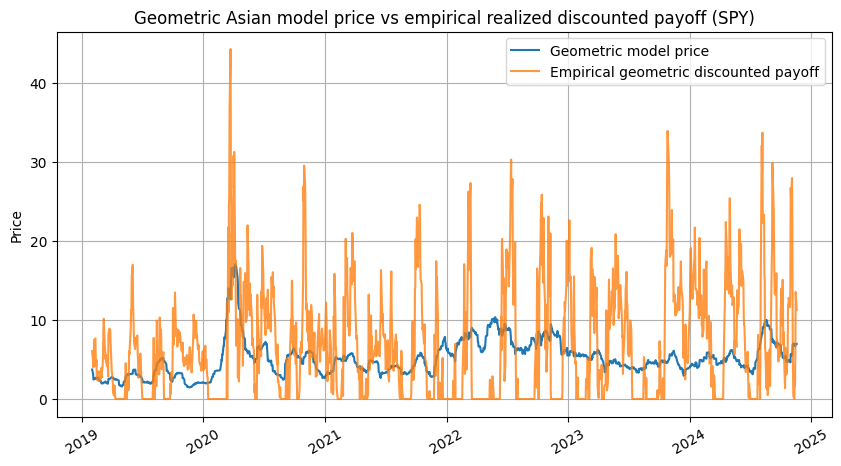

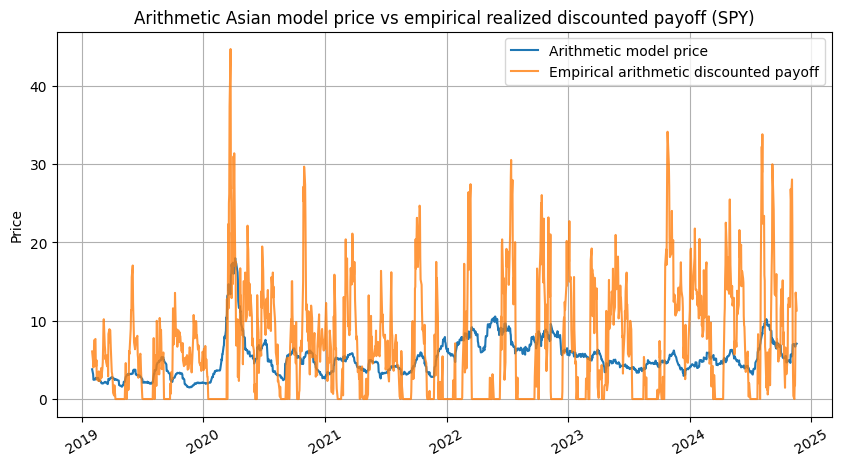

In [ ]:
# --- Basic smmary stats ---
print("Geometric Asian call option")
bias_G = (spy_results["geom_model"] - spy_results["geom_empirical"]).mean()
mae_G = np.mean(np.abs(spy_results["geom_model"] - spy_results["geom_empirical"]))
print(f"Mean model - empirical price: {bias_G:.4f}, MAE: {mae_G:.4f}")
print()
print("Arithmetic Asian call option")
bias_A = (spy_results["arit_model"] - spy_results["arit_empirical"]).mean()
mae_A = np.mean(np.abs(spy_results["arit_model"] - spy_results["arit_empirical"]))
print(f"Mean model - empirical price: {bias_A:.4f}, MAE: {mae_A:.4f}")

# --- Plot model vs empirical over time ---
# geometric
plt.figure(figsize=(10, 5))
plt.plot(spy_results["t0"], spy_results["geom_model"], label="Geometric model price")
plt.plot(
    spy_results["t0"],
    spy_results["geom_empirical"],
    label="Empirical geometric discounted payoff",
    alpha=0.8,
)
plt.legend()
plt.ylabel("Price")
plt.title(
    f"Geometric Asian model price vs empirical realized discounted payoff ({ticker})"
)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

# arithmetic
plt.figure(figsize=(10, 5))
plt.plot(spy_results["t0"], spy_results["arit_model"], label="Arithmetic model price")
plt.plot(
    spy_results["t0"],
    spy_results["arit_empirical"],
    label="Empirical arithmetic discounted payoff",
    alpha=0.8,
)
plt.legend()
plt.ylabel("Price")
plt.title(
    f"Arithmetic Asian model price vs empirical realized discounted payoff ({ticker})"
)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

Geometric call
P&L mean: $1.54
P&L std: $6.84
VaR (95): $-7.79


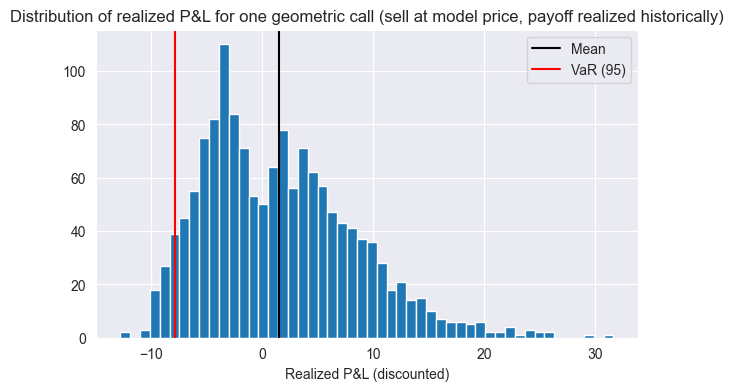

Arithmetic call
P&L mean: $1.55
P&L std: $6.87
VaR (95): $-7.90


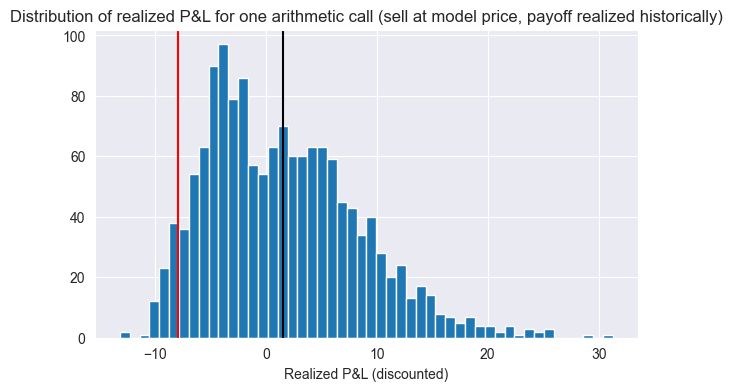

In [ ]:
# --- VaR-like experiment: distribution of P&L if you sold at model price at t0 ---
# pnl = discounted_payoff - model_price (realized payoff minus model price)
spy_results["geom_pnl"] = spy_results["geom_empirical"] - spy_results["geom_model"]
spy_results["arit_pnl"] = spy_results["arit_empirical"] - spy_results["arit_model"]

# geometric
# summary metrics
print("Geometric call")
print(f"P&L mean: ${spy_results['geom_pnl'].mean():.2f}")
print(f"P&L std: ${spy_results['geom_pnl'].std():.2f}")
print(f"VaR (95): ${spy_results['geom_pnl'].quantile(0.05):.2f}")

# histogram
plt.figure(figsize=(7, 4))
plt.hist(spy_results["geom_pnl"], bins=50)
plt.axvline(spy_results["geom_pnl"].mean(), label="Mean", color="black")
plt.axvline(spy_results["geom_pnl"].quantile(0.05), label="VaR (95)", color="red")
plt.title(
    "Distribution of realized P&L for one geometric call (sell at model price, payoff realized historically)"
)
plt.xlabel("Realized P&L (discounted)")
plt.legend()
plt.show()

# arithmetic
# summary metrics
print("Arithmetic call")
print(f"P&L mean: ${spy_results['arit_pnl'].mean():.2f}")
print(f"P&L std: ${spy_results['arit_pnl'].std():.2f}")
print(f"VaR (95): ${spy_results['arit_pnl'].quantile(0.05):.2f}")

# histogram
plt.figure(figsize=(7, 4))
plt.hist(spy_results["arit_pnl"], bins=50)
plt.axvline(spy_results["arit_pnl"].mean(), label="Mean", color="black")
plt.axvline(spy_results["arit_pnl"].quantile(0.05), label="VaR (95)", color="red")
plt.title(
    "Distribution of realized P&L for one arithmetic call (sell at model price, payoff realized historically)"
)
plt.xlabel("Realized P&L (discounted)")
plt.show()

### Vanguard Total Stock Market Index Fund ETF
Next we look at the Vanguard Total Stock Market Index Fund ETF (`VTI`).

In [ ]:
# --- CONFIG ---
ticker = "VTI"
expiry_days = 42  # length of Asian contract in calendar days
trail_window = 21  # days to compute realized vol before t0
r = 0.045  # risk-free rate (annual)
n_sims = 20_000  # MC paths for model pricing
n_steps = expiry_days  # MC time steps approx 1 per day
K_rel = 1.0  # strike relative to spot, e.g., 1.0 = ATM
start_date = "2019-01-01"  # historical range start
end_date = "2024-12-31"  # historical range end

# helper: daily trading days ~ use business days index
prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()

# compute rolling realized vol series (one-sided trailing)
rv = realized_vol(prices, window_days=trail_window)

# choose t0 dates where we have enough trailing data and future window
all_dates = prices.index
usable_dates = []
for t0 in all_dates:
    # require t0 to have trailing window and future expiry window
    t0_idx = all_dates.get_loc(t0)
    if t0_idx - trail_window < 0:
        continue
    # compute end index for expiry
    expiry_date = t0 + pd.Timedelta(days=expiry_days)
    # find nearest trading day >= expiry_date
    if expiry_date > all_dates[-1]:
        break
    # we need expiry to be in index
    # find first trading day >= expiry_date
    future_idx = all_dates.get_indexer([expiry_date], method="bfill")[0]
    if future_idx == -1 or future_idx >= len(all_dates):
        continue
    # accept t0
    usable_dates.append(t0)

# # For speed, subsample usable_dates
# usable_dates = usable_dates[::20]

results = []
for t0 in usable_dates:
    # get S0 at t0
    S0 = float(prices.loc[t0])
    # strike
    K = K_rel * S0

    # compute realized vol at t0 using trailing window
    sigma_t0 = float(rv.loc[t0])
    if np.isnan(sigma_t0) or sigma_t0 <= 0:
        continue

    # determine expiry trading day index
    expiry_date = t0 + pd.Timedelta(days=expiry_days)
    expiry_idx = prices.index.get_indexer([expiry_date], method="bfill")[0]
    T_days = expiry_idx - prices.index.get_indexer([t0])[0]
    # convert to years
    T_years = T_days / 252.0

    # --- Model price at t0 using realized vol ---
    # geometric
    model_G_price = gao_price(S0, K, sigma_t0, T_years, r)
    # arithmetic
    model_A_price = monte_carlo_asian(
        S0, K, sigma_t0, T_years, r, 0, n_sims, n_steps, return_distribution=False
    )

    # --- Empirical realized payoff computed from actual future prices ---
    # we need the actual average from t0->expiry_date inclusive
    # get slice of future prices from the first trading day after t0 up to expiry_idx
    t0_idx = prices.index.get_loc(t0)
    future_slice = prices.iloc[
        t0_idx + 1 : expiry_idx + 1
    ]  # average over next T_days (exclude t0)
    if len(future_slice) == 0:
        continue

    # geometric average
    G_T = np.exp(np.mean(np.log(future_slice)))
    discounted_G_payoff = max(G_T - K, 0) * np.exp(-r * T_years)

    # arithmetic average
    A_T = np.mean(future_slice)
    discounted_A_payoff = max(A_T - K, 0) * np.exp(-r * T_years)

    # store
    results.append(
        {
            "t0": t0,
            "S0": S0,
            "K": K,
            "sigma_t0": sigma_t0,
            "T_years": T_years,
            "geom_model": model_G_price,
            "arit_model": model_A_price,
            "geom_empirical": discounted_G_payoff,
            "arit_empirical": discounted_A_payoff,
        }
    )

vti_results = pd.DataFrame(results)
vti_results = vti_results.dropna().reset_index(drop=True)
vti_results

/tmp/ipykernel_11398/288267783.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start_date, end=end_date)['Close'].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_11398/288267783.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.loc[t0])
/tmp/ipykernel_11398/288267783.py:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_t0 = float(rv.loc[t0])


,t0,S0,K,sigma_t0,T_years,geom_model,arit_model,geom_empirical,arit_empirical
0,2019-02-01,124.977310,124.977310,0.180145,0.115079,1.897391,1.897215,3.235106,3.245217
1,2019-02-04,125.869202,125.869202,0.150243,0.115079,1.625194,1.638063,2.527768,2.538101
2,2019-02-05,126.391663,126.391663,0.113147,0.115079,1.275123,1.266485,2.169027,2.179657
3,2019-02-06,126.265533,126.265533,0.112227,0.115079,1.265008,1.270238,2.441893,2.452239
4,2019-02-07,125.067368,125.067368,0.118042,0.115079,1.308385,1.322266,3.875170,3.884960
...,...,...,...,...,...,...,...,...,...
1455,2024-11-12,292.684387,292.684387,0.140587,0.115079,3.564161,3.596175,0.868607,0.893463
1456,2024-11-13,292.546173,292.546173,0.137597,0.115079,3.495936,3.474392,1.074449,1.099293
1457,2024-11-14,290.383392,290.383392,0.140412,0.111111,3.464984,3.496689,3.342536,3.367607
1458,2024-11-15,286.699738,286.699738,0.148311,0.111111,3.590370,3.644058,7.175740,7.198063


Geometric Asian call option
Mean model - empirical price: -0.7486, MAE: 2.8529

Arithmetic Asian call option
Mean model - empirical price: -0.7526, MAE: 2.8670


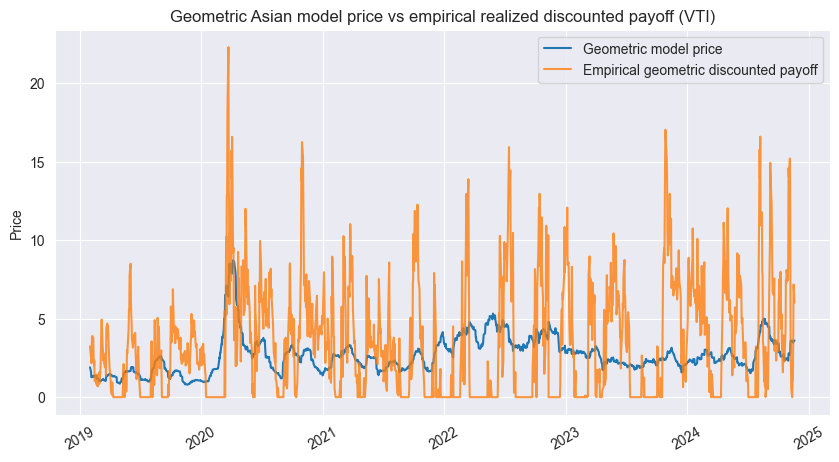

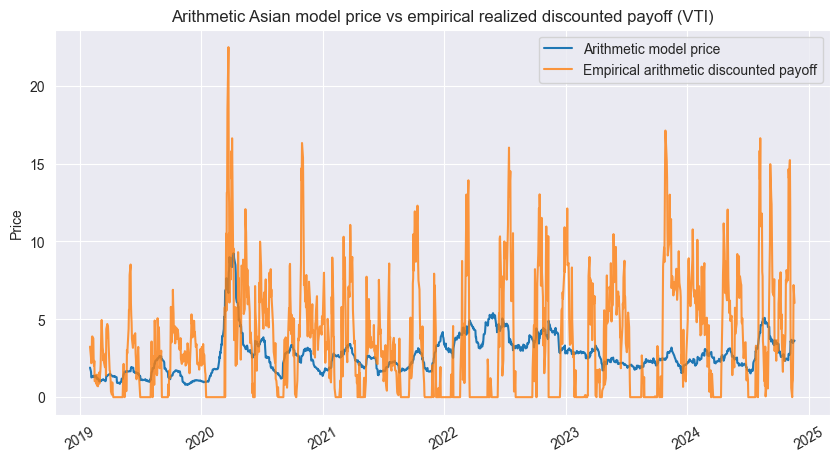

In [ ]:
# --- Basic smmary stats ---
print("Geometric Asian call option")
bias_G = (vti_results["geom_model"] - vti_results["geom_empirical"]).mean()
mae_G = np.mean(np.abs(vti_results["geom_model"] - vti_results["geom_empirical"]))
print(f"Mean model - empirical price: {bias_G:.4f}, MAE: {mae_G:.4f}")
print()
print("Arithmetic Asian call option")
bias_A = (vti_results["arit_model"] - vti_results["arit_empirical"]).mean()
mae_A = np.mean(np.abs(vti_results["arit_model"] - vti_results["arit_empirical"]))
print(f"Mean model - empirical price: {bias_A:.4f}, MAE: {mae_A:.4f}")

# --- Plot model vs empirical over time ---
# geometric
plt.figure(figsize=(10, 5))
plt.plot(vti_results["t0"], vti_results["geom_model"], label="Geometric model price")
plt.plot(
    vti_results["t0"],
    vti_results["geom_empirical"],
    label="Empirical geometric discounted payoff",
    alpha=0.8,
)
plt.legend()
plt.ylabel("Price")
plt.title(
    f"Geometric Asian model price vs empirical realized discounted payoff ({ticker})"
)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

# arithmetic
plt.figure(figsize=(10, 5))
plt.plot(vti_results["t0"], vti_results["arit_model"], label="Arithmetic model price")
plt.plot(
    vti_results["t0"],
    vti_results["arit_empirical"],
    label="Empirical arithmetic discounted payoff",
    alpha=0.8,
)
plt.legend()
plt.ylabel("Price")
plt.title(
    f"Arithmetic Asian model price vs empirical realized discounted payoff ({ticker})"
)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

Geometric call
P&L mean: $0.75
P&L std: $3.52
VaR (95): $-4.00


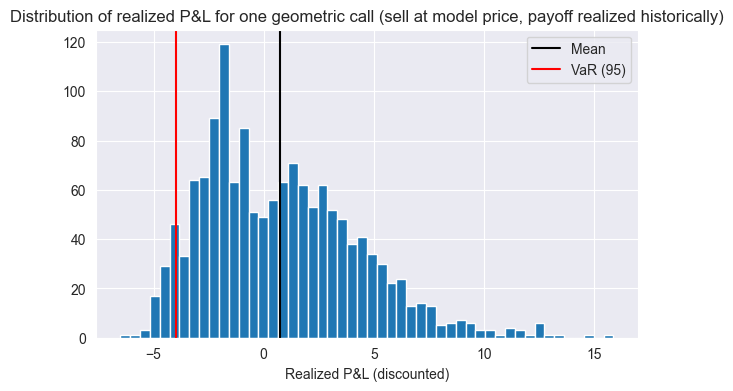

Arithmetic call
P&L mean: $0.75
P&L std: $3.54
VaR (95): $-3.99


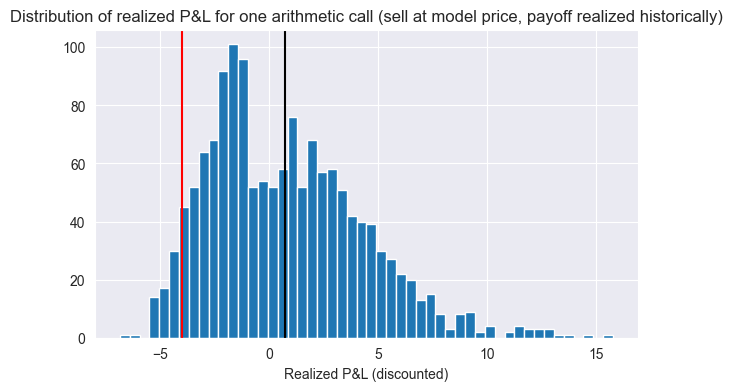

In [ ]:
# --- VaR-like experiment: distribution of P&L if you sold at model price at t0 ---
# pnl = discounted_payoff - model_price (realized payoff minus model price)
vti_results["geom_pnl"] = vti_results["geom_empirical"] - vti_results["geom_model"]
vti_results["arit_pnl"] = vti_results["arit_empirical"] - vti_results["arit_model"]

# geometric
# summary metrics
print("Geometric call")
print(f"P&L mean: ${vti_results['geom_pnl'].mean():.2f}")
print(f"P&L std: ${vti_results['geom_pnl'].std():.2f}")
print(f"VaR (95): ${vti_results['geom_pnl'].quantile(0.05):.2f}")

# histogram
plt.figure(figsize=(7, 4))
plt.hist(vti_results["geom_pnl"], bins=50)
plt.axvline(vti_results["geom_pnl"].mean(), label="Mean", color="black")
plt.axvline(vti_results["geom_pnl"].quantile(0.05), label="VaR (95)", color="red")
plt.title(
    "Distribution of realized P&L for one geometric call (sell at model price, payoff realized historically)"
)
plt.xlabel("Realized P&L (discounted)")
plt.legend()
plt.show()

# arithmetic
# summary metrics
print("Arithmetic call")
print(f"P&L mean: ${vti_results['arit_pnl'].mean():.2f}")
print(f"P&L std: ${vti_results['arit_pnl'].std():.2f}")
print(f"VaR (95): ${vti_results['arit_pnl'].quantile(0.05):.2f}")

# histogram
plt.figure(figsize=(7, 4))
plt.hist(vti_results["arit_pnl"], bins=50)
plt.axvline(vti_results["arit_pnl"].mean(), label="Mean", color="black")
plt.axvline(vti_results["arit_pnl"].quantile(0.05), label="VaR (95)", color="red")
plt.title(
    "Distribution of realized P&L for one arithmetic call (sell at model price, payoff realized historically)"
)
plt.xlabel("Realized P&L (discounted)")
plt.show()